In [71]:
import pandas as pd
import matplotlib.pyplot as plt

calls_df = pd.read_csv('callsf0d4f5a.csv')
reasons_df = pd.read_csv('reason18315ff.csv')

merged_df = pd.merge(calls_df, reasons_df, on='call_id')

merged_df.isnull().sum()  # Check for missing values
merged_df.dropna(subset=['call_transcript', 'primary_call_reason'], inplace=True)  # Drop missing transcripts or reasons

merged_df['primary_call_reason'] = merged_df['primary_call_reason'].str.strip().str.lower()

In [72]:
merged_df['primary_call_reason'] = (
    merged_df['primary_call_reason']
    .str.strip()  # Remove leading/trailing spaces
    .str.lower()  # Convert to lowercase for consistency
    .str.replace(r'\s+', ' ', regex=True)  # Replace multiple spaces with a single space
)

cleaned_call_frequency = merged_df['primary_call_reason'].value_counts()

print(cleaned_call_frequency)

primary_call_reason
irrops                   13311
voluntary change         10848
seating                   6365
mileage plus              5851
post-flight               3957
communications            3840
products and services     2856
baggage                   2832
upgrade                   2738
booking                   2637
checkout                  1888
voluntary cancel          1607
check-in                  1519
digital support           1225
etc                        952
traveler updates           937
other topics               818
schedule change            731
products & services        476
disability                 403
check in                   385
post flight                373
unaccompanied minor        104
Name: count, dtype: int64


In [74]:
# Define self-solvable issues (based on your observations)
self_solvable_reasons = [
    'seating', 'mileage plus', 'booking', 'check-in',
    'voluntary cancel', 'digital support', 'traveler updates', 'schedule change'
]

# Filter out self-solvable calls
self_solvable_df = merged_df[merged_df['primary_call_reason'].isin(self_solvable_reasons)]

# Check the frequency of self-solvable reasons
call_frequency = self_solvable_df['primary_call_reason'].value_counts()
print("Self-solvable call reason frequencies:")
print(call_frequency)

Self-solvable call reason frequencies:
primary_call_reason
seating             6365
mileage plus        5851
booking             2637
voluntary cancel    1607
check-in            1519
digital support     1225
traveler updates     937
schedule change      731
Name: count, dtype: int64


In [76]:
sentiment = pd.read_csv('sentiment_statisticscc1e57a.csv')

In [108]:
sentiment.customer_tone.unique()

array(['angry', 'neutral', 'polite', 'frustrated', 'calm'], dtype=object)

In [110]:
merged_df['sentiment']= sentiment['average_sentiment']
merged_df['customer_tone'] = sentiment['customer_tone']

In [79]:
merged_df['call_start_datetime'] = pd.to_datetime(merged_df['call_start_datetime'])
merged_df['agent_assigned_datetime'] = pd.to_datetime(merged_df['agent_assigned_datetime'])
merged_df['call_end_datetime'] = pd.to_datetime(merged_df['call_end_datetime'])

In [81]:
# calls['waiting_time(in min)'] = (calls['agent_assigned_datetime'] - calls['call_start_datetime']).dt.total_seconds() / 60
merged_df['handle_time(in min)'] = (merged_df['call_end_datetime'] - merged_df['agent_assigned_datetime']).dt.total_seconds() / 60

In [84]:
merged_df.drop(columns=['call_transcript','call_start_datetime','agent_assigned_datetime','call_end_datetime'],inplace=True)

In [111]:
merged_df.head()

,call_id,customer_id,agent_id,primary_call_reason,sentiment,handle_time(in min),sentiment_class,routing_decision,feedback,customer_tone
0,4667960400,2033123310,963118,voluntary cancel,-0.04,31.0,positive,Transfer to Agent,Review IVR failure and improve options,angry
1,1122072124,8186702651,519057,booking,0.02,12.0,positive,Resolve via IVR,IVR success,neutral
2,6834291559,2416856629,158319,irrops,-0.13,19.0,positive,Resolve via IVR,Non self-solvable issue,polite
3,2266439882,1154544516,488324,upgrade,-0.20,7.0,neutral,Resolve via IVR,Non self-solvable issue,frustrated
4,1211603231,5214456437,721730,seating,-0.05,9.0,positive,Transfer to Agent,Review IVR failure and improve options,polite


### classify reasons for IVR via sentiments

sentiment_class      negative  neutral  positive
primary_call_reason                             
booking                  1429      312       896
check-in                  813      180       526
digital support           619      173       433
mileage plus             3148      710      1993
schedule change           394       83       254
seating                  3479      732      2154
traveler updates          499      131       307
voluntary cancel          863      210       534


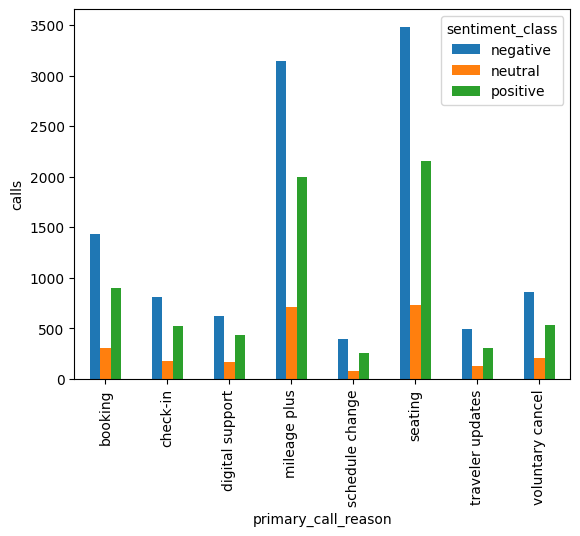

In [117]:
# Classify sentiment into positive, negative, and neutral
def classify_sentiment(polarity):
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

merged_df['sentiment_class'] = merged_df['sentiment'].apply(classify_sentiment)

# Analyze how sentiment correlates with self-solvable reasons
self_solvable_sentiment = merged_df[merged_df['primary_call_reason'].isin(self_solvable_reasons)]
sentiment_distribution = self_solvable_sentiment.groupby('primary_call_reason')['sentiment_class'].value_counts().unstack()
sentiment_distribution.plot(kind='bar')
plt.ylabel('calls')
print(sentiment_distribution)

### classify reasons for IVR via customer tone

classify_tone        negitive  neutral  positive
primary_call_reason                             
booking                  1023     1114       500
check-in                  599      599       321
digital support           500      498       227
mileage plus             2282     2374      1195
schedule change           285      314       132
seating                  2574     2541      1250
traveler updates          381      379       177
voluntary cancel          642      633       332


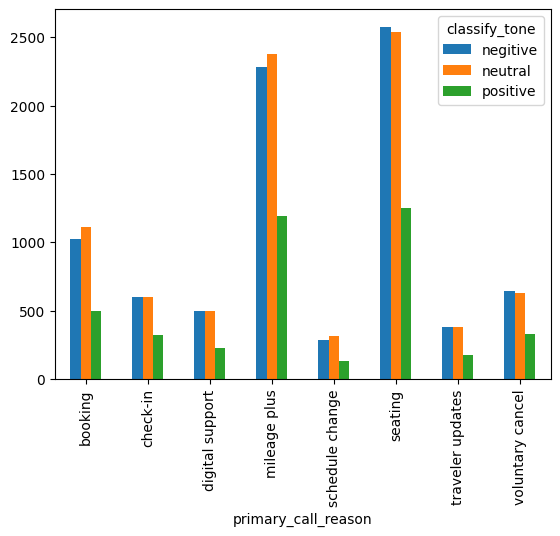

In [114]:
# Classify sentiment into positive, negative, and neutral by customer tone : 'angry', 'neutral', 'polite', 'frustrated', 'calm'
def classify_tone(tone):
    if tone == 'polite':
        return 'positive'
    elif tone == 'neutral' or tone == 'calm':
        return 'neutral'
    else:
        return 'negitive'

merged_df['classify_tone'] = merged_df['customer_tone'].apply(classify_tone)

# Analyze how sentiment correlates with self-solvable reasons
self_solvable_sentiment = merged_df[merged_df['primary_call_reason'].isin(self_solvable_reasons)]
sentiment_distribution_tone = self_solvable_sentiment.groupby('primary_call_reason')['classify_tone'].value_counts().unstack()
sentiment_distribution_tone.plot(kind='bar')
plt.ylabel('self-solvable_reasons')
print(sentiment_distribution_tone)

In [26]:
# Define IVR options based on most frequent self-solvable reasons
ivr_options = {
    "1": "Cancel your booking.",
    "2": "Check your booking or flight status.",
    "3": "View or change your seat assignment.",
    "4": "Check your Mileage Plus balance.",
    "5": "Check-in for your flight.",
    "6": "Review schedule changes and rebook.",
    "7": "Get traveler-related updates.",
    "8": "Reset your password or resolve account issues."
}

# Display proposed IVR options
print("Proposed IVR Options:")
for key, value in ivr_options.items():
    print(f"Option {key}: {value}")


Proposed IVR Options:
Option 1: Cancel your booking.
Option 2: Check your booking or flight status.
Option 3: View or change your seat assignment.
Option 4: Check your Mileage Plus balance.
Option 5: Check-in for your flight.
Option 6: Review schedule changes and rebook.
Option 7: Get traveler-related updates.
Option 8: Reset your password or resolve account issues.


Number of escalations to agents for self-solvable issues: 11244
routing_decision
Resolve via IVR      55409
Transfer to Agent    11244
Name: count, dtype: int64


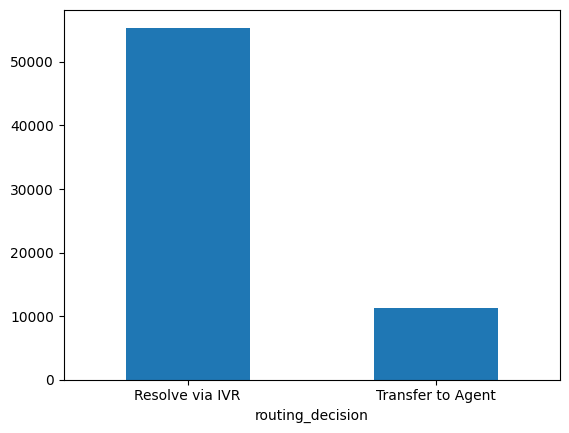

In [95]:
# Contextual Call Routing
# Check how many self-solvable issues escalated to agents
self_solvable_escalations = merged_df[
    (merged_df['primary_call_reason'].isin(self_solvable_reasons)) & 
    (merged_df['sentiment_class'] == 'negative')
]

# Get the number of escalations and propose agent transition strategies
escalation_count = self_solvable_escalations.shape[0]
print(f"Number of escalations to agents for self-solvable issues: {escalation_count}")

# Implement strategy for smooth agent transition
def route_to_agent(call_reason, sentiment_class):
    if call_reason in self_solvable_reasons and sentiment_class == 'negative':
        return "Transfer to Agent"
    return "Resolve via IVR"

merged_df['routing_decision'] = merged_df.apply(
    lambda row: route_to_agent(row['primary_call_reason'], row['sentiment_class']), axis=1
)

# Display routing decisions
routing_decisions = merged_df['routing_decision'].value_counts()
print(routing_decisions)


routing_decisions.plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

In [96]:
merged_df.head()

,call_id,customer_id,agent_id,primary_call_reason,sentiment,handle_time(in min),sentiment_class,routing_decision
0,4667960400,2033123310,963118,voluntary cancel,-0.04,31.0,negative,Transfer to Agent
1,1122072124,8186702651,519057,booking,0.02,12.0,positive,Resolve via IVR
2,6834291559,2416856629,158319,irrops,-0.13,19.0,negative,Resolve via IVR
3,2266439882,1154544516,488324,upgrade,-0.20,7.0,negative,Resolve via IVR
4,1211603231,5214456437,721730,seating,-0.05,9.0,negative,Transfer to Agent


In [102]:
merged_df.groupby('routing_decision')['handle_time(in min)'].mean()

routing_decision
Resolve via IVR      11.831580
Transfer to Agent    10.575062
Name: handle_time(in min), dtype: float64

In [103]:
# Create a feedback loop to monitor IVR performance and sentiment
def monitor_feedback(call_reason, sentiment_class):
    if call_reason in self_solvable_reasons:
        if sentiment_class == 'negative':
            return "Review IVR failure and improve options"
        else:
            return "IVR success"
    else:
        return "Non self-solvable issue"

# Apply the feedback loop
merged_df['feedback'] = merged_df.apply(
    lambda row: monitor_feedback(row['primary_call_reason'], row['sentiment_class']), axis=1
)

# Display feedback loop results
feedback_summary = merged_df['feedback'].value_counts()
print(feedback_summary)

feedback
Non self-solvable issue                   45781
Review IVR failure and improve options    11244
IVR success                                9628
Name: count, dtype: int64
